# Welcome!


Hello, and welcome to the student notebook of the **Deep Learning Deep Dive Workshop**!


You can open this notebook in google colab at: https://bit.ly/3h5T9Tw

For this session we will be using the excellent **fast.ai** library (https://www.fast.ai/).   
If you get an import error you might need to upgrade the fast.ai library, which you can do by  running the cell below:

In [ ]:
!pip install --upgrade git+https://github.com/fastai/fastai.git

# Prepare the data

We are using a synthetic dataset with 2500 images that were generated algoritmically.

The images will contain lines of different widths and orientations arranged as:

* Vertical Lines
* Horizontal Lines
* Decreasing Lines (\\)
* Increasing Lines (/)
* Crosses (x)
* Pluses (+)
* Circles
* Triangles
* Squares
* Nothing (no lines, sometimes has a little bit of noise)

Note that there is small amount of *bad data* in this dataset:

* A bit of overlap between some classes such as 
  * increasing with either horizontal or vertical
  * decreasing with either horizontal or vertical
* squares that look like triangles beacuse two sides are almost colinear
* ellipses that look like lines because one of their radiuses is too small
* Crosses and Pluses that look like lines because one of their lines is too small
  
This is great for experimenting with the effects of bad labels in both training and evaluation outcomes.    
We will address the `most_confused` classes later in the notebook.

## Get images for training

To get all the images we will use the convenience function `get_image_files` that returns a list of all the images under a given folder (including sub-folders).

In [1]:
%matplotlib inline

from fastai.vision.all import *
from fastai.metrics import error_rate
from pathlib import Path

# Change your configuration here
num_epochs = 3                   # Number of epochs
num_images_per_class = 200       # Number of images to use for each class, the maximum is 2000. NOTE: Half are used for training, half for validation


# Fetch the compressed dataset from github and uncompress it
data_folder = untar_data("https://github.com/zevarela/DeepLearningDeepDive/blob/main/data/geometric.tgz?raw=True")
train_folder = data_folder / "train"
holdout_folder = data_folder / "holdout"

# image_paths = get_image_files(train_folder) 
# We don't want to use all 2k images for each class, just the first *num_images_per_class*
image_paths = [file for file in get_image_files(train_folder) if  int(file.with_suffix('').name.split("_")[-1]) < num_images_per_class]

print(f'Training {num_epochs} epochs using {num_images_per_class//2} images per class for training, and another {num_images_per_class//2} for validation.')
print(f'Sample files: {image_paths[0].name}, {image_paths[-1].name}')

Training 3 epochs using 100 images per class for training, and another 100 for validation.
Sample files: increasing_000074.png, plus_000197.png


## Get label from path

Label is the name we want to predict when we classify the image. 

A common way to get the labels in fast.ai is by using a part of the image file name or path.

In our dataset the files are labeled `label_nnnnnn.png` so the label is just the part of the file name before the first underscore.

In [2]:
def get_target_from_path(x):
    return x.name.split('_')[0]

print('Target labels for sample files: ',get_target_from_path(image_paths[0]), get_target_from_path(image_paths[-1]) )

Target labels for sample files:  increasing plus


# Create the Data Loaders

DataLoaders perform all the actions needed to get te data into the model. To train the model we need two DataLoaders:

* training DataLoader feeds the data as it is used to tune the model during training
* validation DataLoader gives the data that is used to evaluate the model after each training epoch (a full pass of the training DataLoader).

Fast.ai has a convenient factory function `ImageDataLoaders.from_path_func` to help us create these dataloaders. 

Here's what the parameters we are passing below mean:

* `data_folder` the folder where the train and validation images are kept
* `image_paths` a list of Path objects for train (and validation) images
* `get_target_from_path` a function that returns the class label from the image's Path object
* `bs` the size of the batch (images are grouped for faster processing in the GPU, and some other processing steps such as batch normalization, etc )
* `valid_pct` the ratio of images to use as the validation set (0.5 = 50% of the images will be used for validation)
* `batch_tfms` the transforms we want to apply to the images 

In [3]:
dls = ImageDataLoaders.from_path_func(train_folder, image_paths, 
                                      get_target_from_path, 
                                      bs=64, valid_pct=0.5, batch_tfms=[Normalize])

# Take a look at the training data

A batch is a sequence of images that are used for training (or validating) the model. 

Batching is one of the tasks that the DataLoaders perform in fast.ai. Another is hosting convenience methods such as `show_batch` that allows us to see the batch inputs:

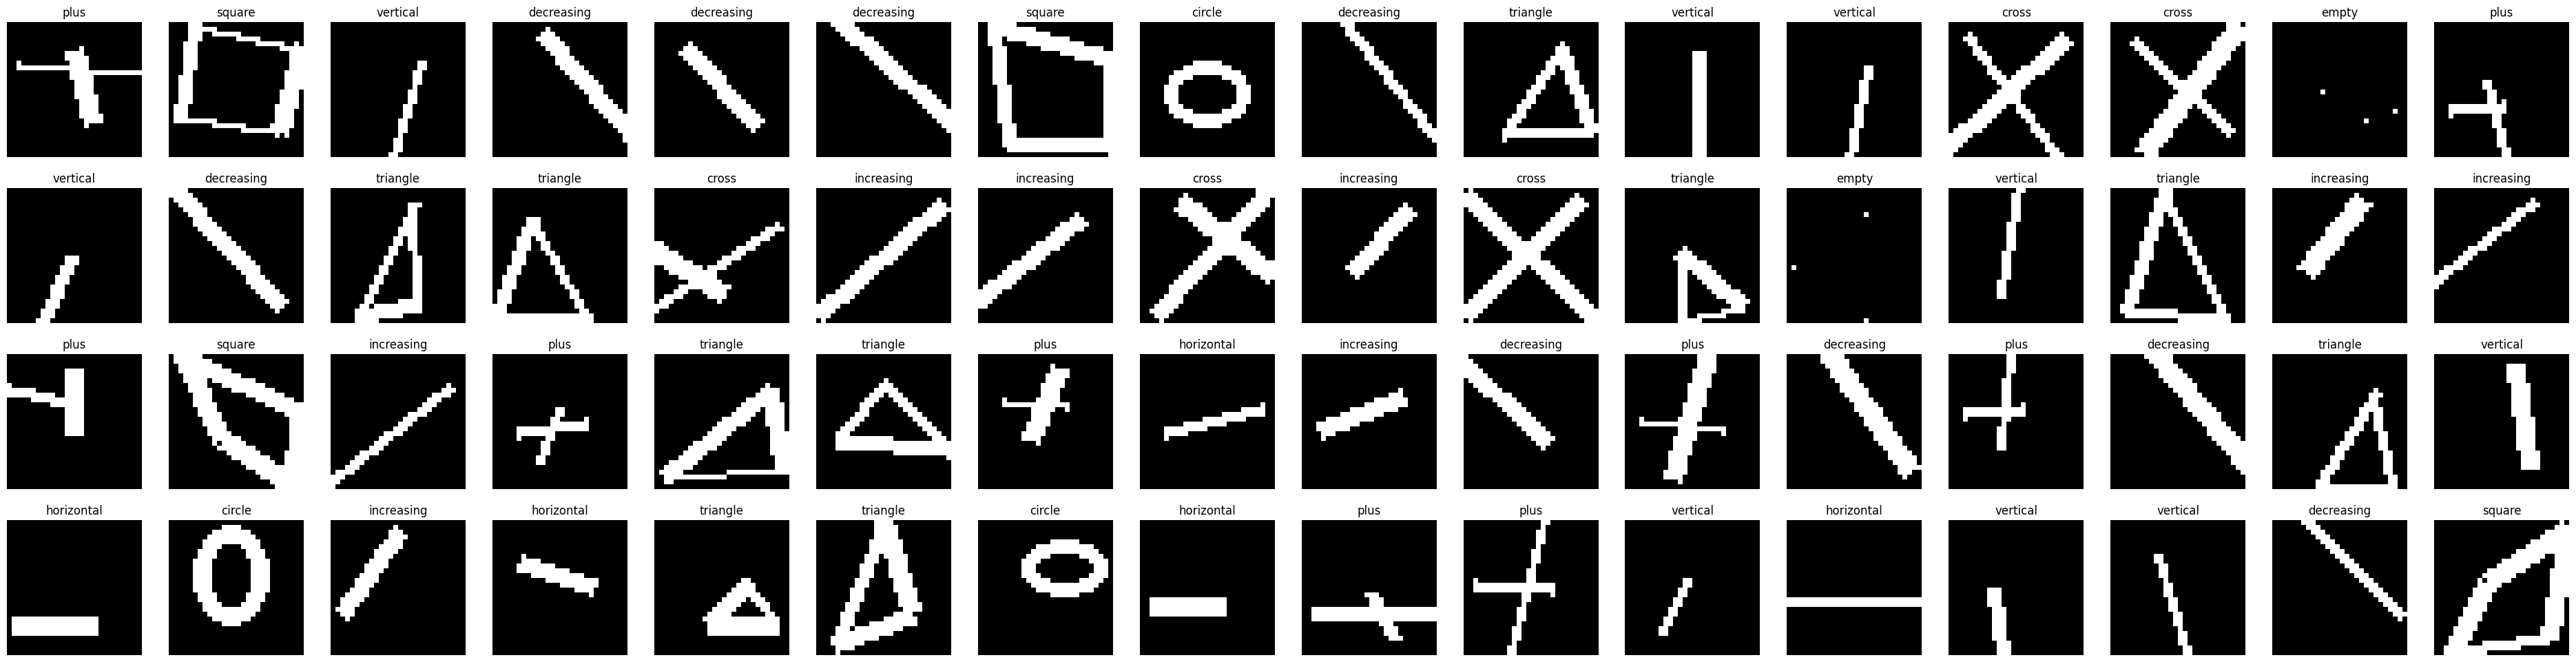

In [4]:
dls.show_batch(max_n=64, ncols=16)

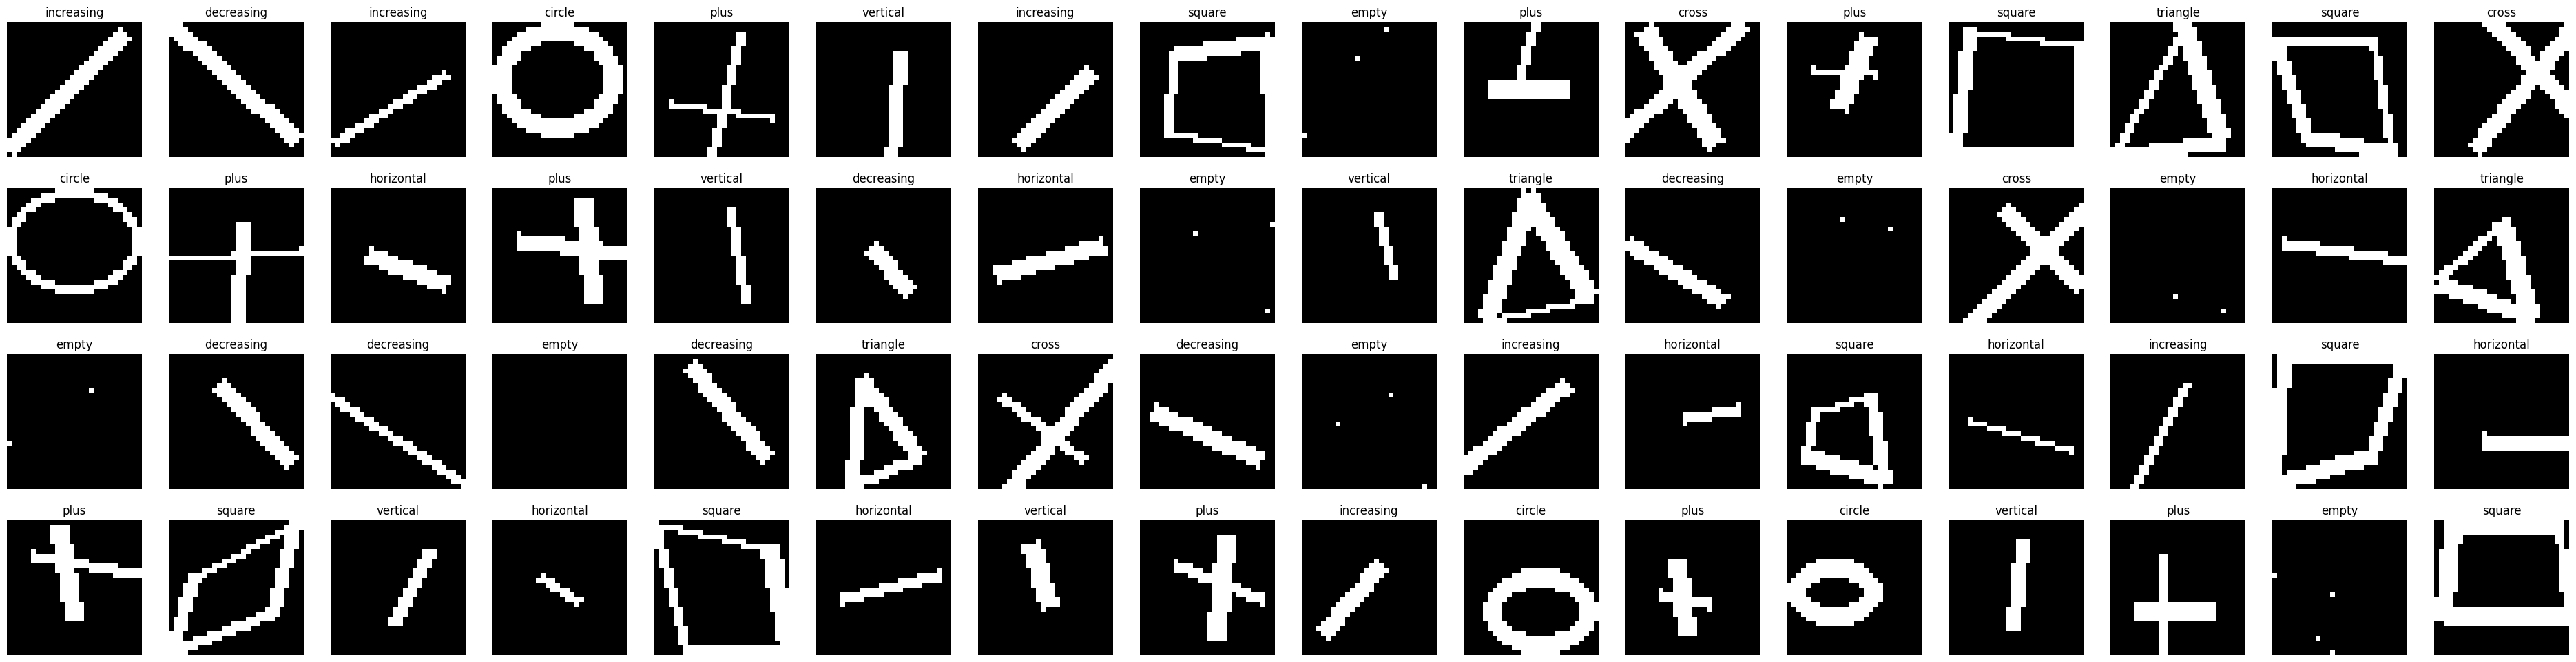

In [5]:
dls.show_batch(max_n=64, ncols=16)

# Create the model

Having the DataLoaders we are now ready to train the model. First we select the kind of model we want.

Because this task is quite simple, we will use a basic `resnet18` model.

Let's take a quick look at what's inside:

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.summary()

Sequential (Input shape: 64 x 3 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 14 x 14   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 7 x 7     
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                        

# Find a good learning rate

A good LR is essential to train a model efficiently. 

The fast.ai has a learning rate finder algorithm that usually finds a great LR to train your model:

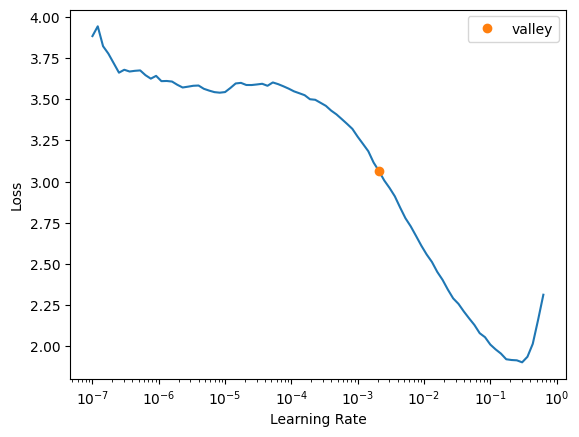

In [8]:
v = learn.lr_find()

# Fine tuning instead of training

Using the LR we found in the previous step, we can now perform a fine-tuning of the fastai model that was previously trainined on other image classification tasks, thus making training much quicker.

In [9]:
learn.fine_tune(num_epochs, v.valley)

epoch,train_loss,valid_loss,error_rate,time
0,2.518004,1.270682,0.464000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.904549,0.722832,0.222000,00:01
1,0.643894,0.579195,0.173000,00:01
2,0.468951,0.423153,0.128000,00:01


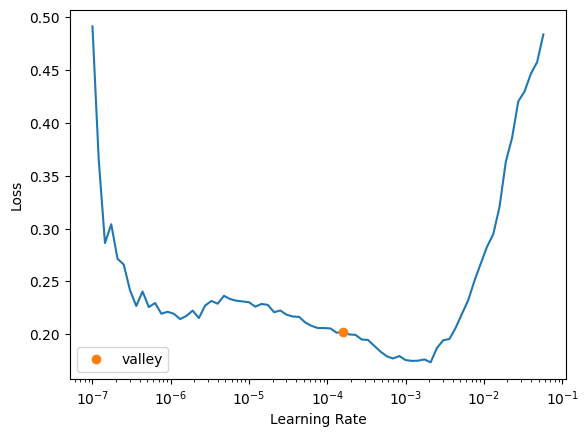

In [10]:
v = learn.lr_find()

In [11]:
learn.fit_one_cycle(num_epochs, v.valley)

epoch,train_loss,valid_loss,error_rate,time
0,0.190243,0.296258,0.086000,00:01
1,0.156199,0.236700,0.067000,00:01
2,0.126190,0.243325,0.064000,00:01


# Visualize model predictions

So now we have a trained model!! Let's test it out:

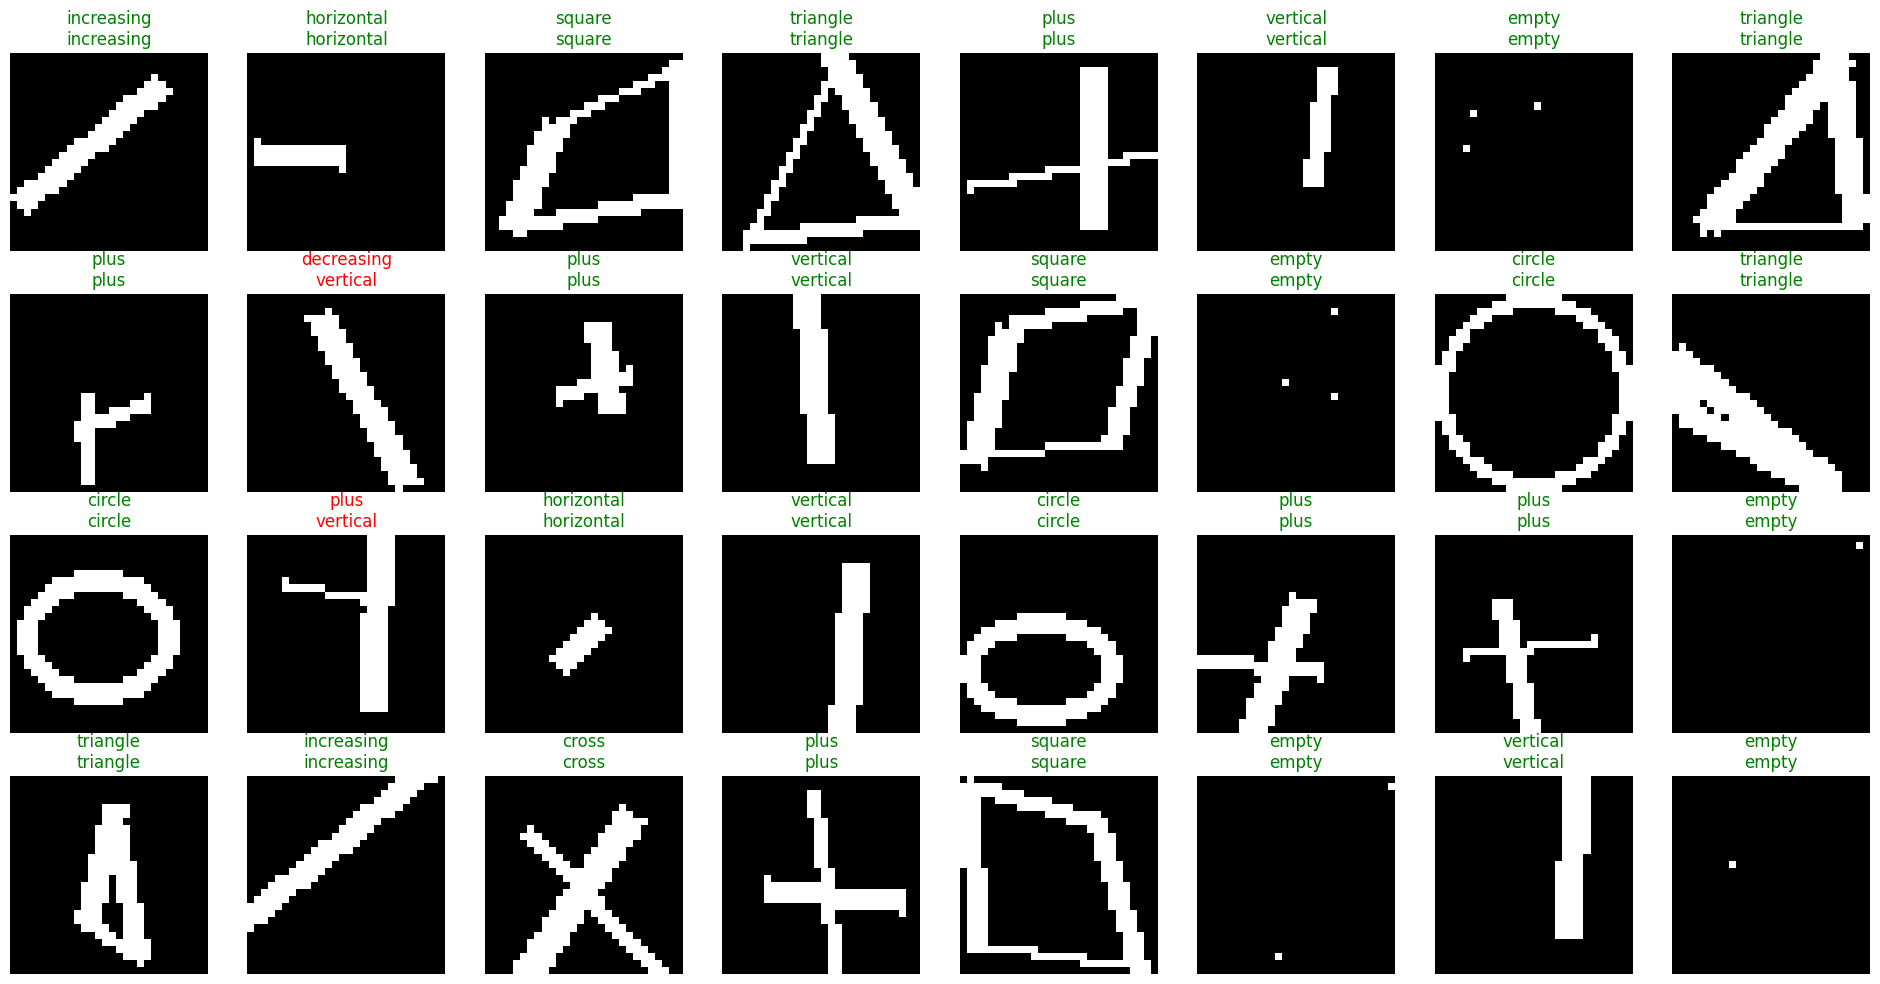

In [12]:
learn.show_results(max_n=64, ncols=8, nrows=4)

# Model evaluation on the validation set

That looks pretty good! Since we kept half of our images to validate the model, let's use them to evaluate the model performance

              precision    recall  f1-score   support

      circle       1.00      0.98      0.99       112
       cross       0.94      0.92      0.93       107
  decreasing       0.90      0.92      0.91        98
       empty       1.00      1.00      1.00        98
  horizontal       0.90      0.97      0.93        97
  increasing       0.97      0.93      0.95        99
        plus       0.93      0.86      0.90       110
      square       0.97      0.91      0.94        93
    triangle       0.92      0.94      0.93        90
    vertical       0.84      0.93      0.88        96

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



Confused more than 10 times: 



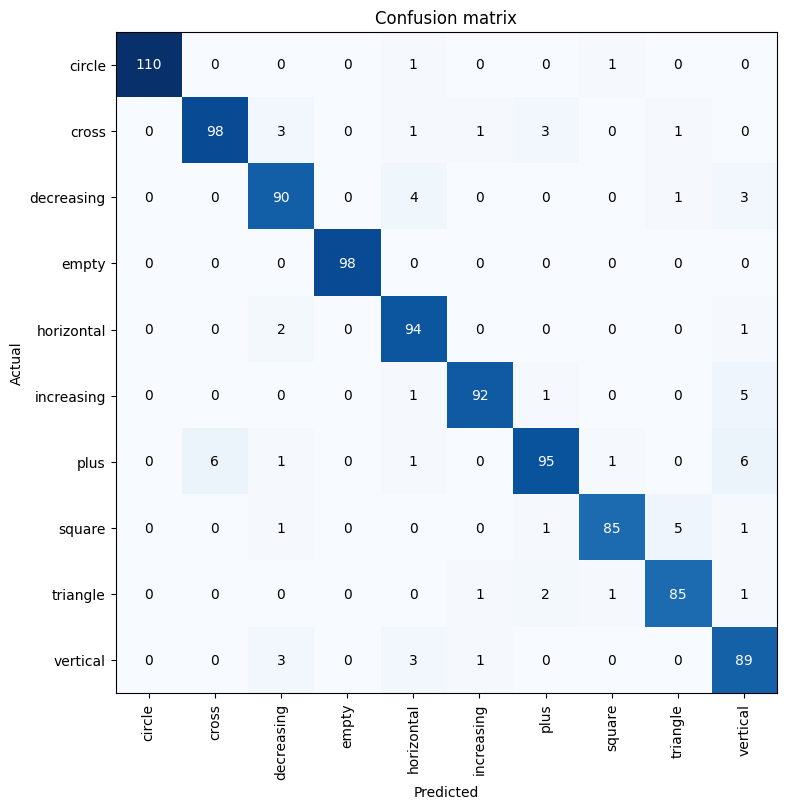

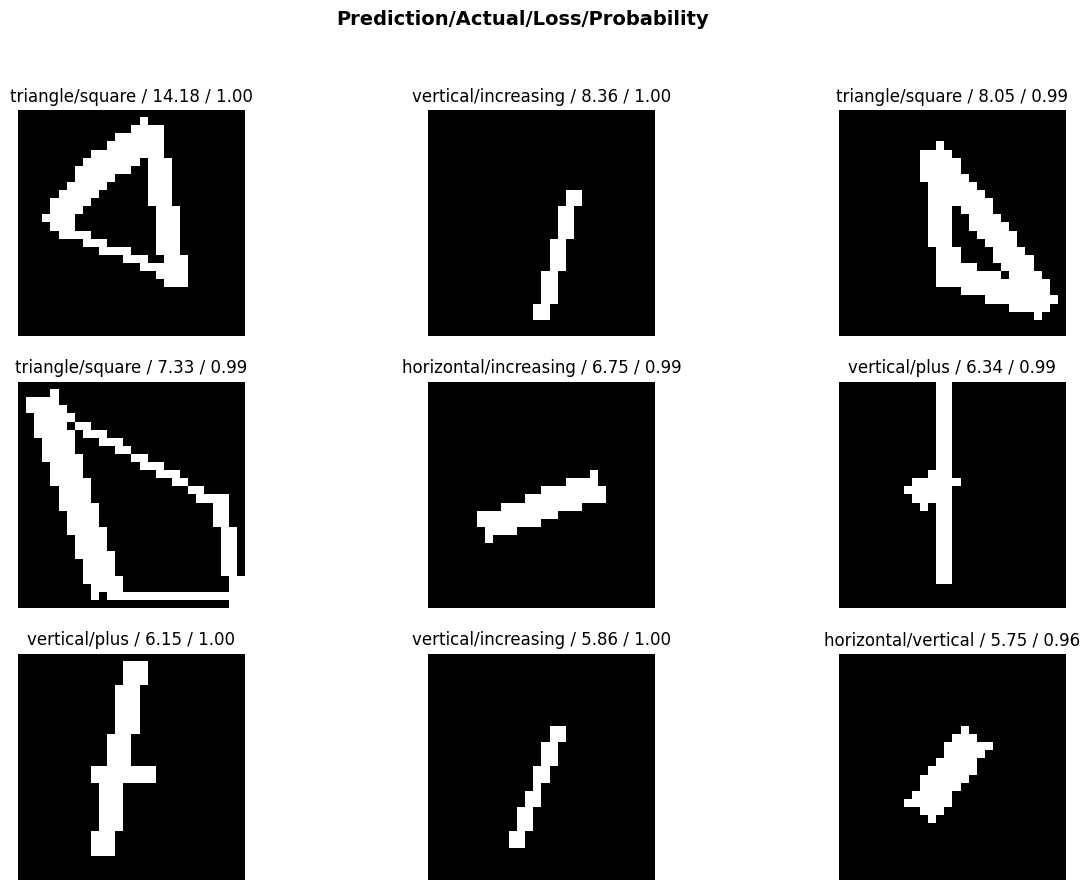

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()
print("Confused more than 10 times: \n"+"\n".join([f"    - '{a}' was confused with '{b}' {c} times" for a,b,c in interp.most_confused(min_val=10)]))
interp.plot_confusion_matrix(figsize=(8,8))
interp.plot_top_losses(k=9, figsize=(15,10))

# Evaluate the model with the holdout set

Since the validation set was already used to decide when to stop training, we should also test the model on data that the model never saw.

That data is the holdout set, and here are the results:

              precision    recall  f1-score   support

      circle       1.00      0.99      0.99       491
       cross       0.95      0.95      0.95       481
  decreasing       0.93      0.92      0.92       503
       empty       0.99      1.00      0.99       496
  horizontal       0.85      0.97      0.91       521
  increasing       0.93      0.94      0.94       499
        plus       0.98      0.81      0.88       517
      square       0.97      0.92      0.95       500
    triangle       0.94      0.90      0.92       513
    vertical       0.85      0.96      0.90       479

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



Confused more than 10 times: 
    - 'plus' was confused with 'vertical' 44 times
    - 'plus' was confused with 'horizontal' 38 times
    - 'square' was confused with 'triangle' 23 times
    - 'decreasing' was confused with 'horizontal' 21 times
    - 'increasing' was confused with 'vertical' 18 times
    - 'triangle' was confused with 'increasing' 16 times
    - 'plus' was confused with 'cross' 13 times
    - 'decreasing' was confused with 'vertical' 12 times
    - 'triangle' was confused with 'square' 11 times
    - 'cross' was confused with 'decreasing' 10 times
    - 'vertical' was confused with 'decreasing' 10 times


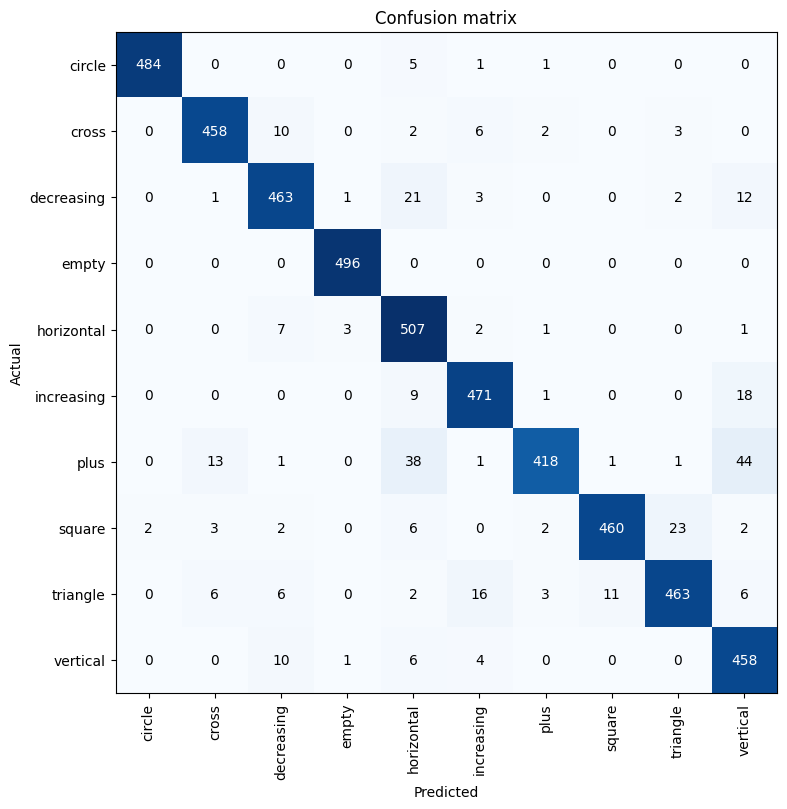

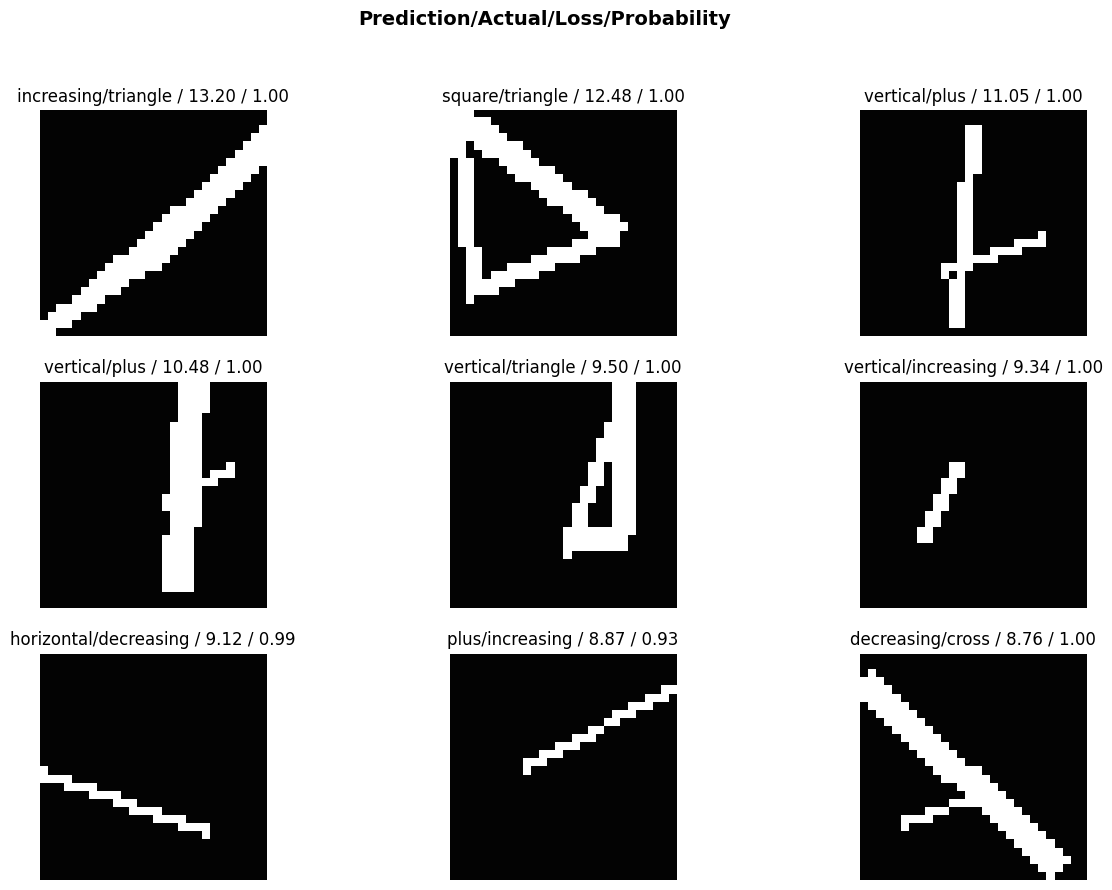

In [14]:
holdout_image_paths = get_image_files(holdout_folder)
test_dls = ImageDataLoaders.from_path_func(holdout_folder, holdout_image_paths, get_target_from_path, bs=10, valid_pct=0.5, shuffle=True, batch_tfms=[Normalize])
t_interp = ClassificationInterpretation.from_learner(learn, dl=test_dls.train)
t_interp.print_classification_report()
print("Confused more than 10 times: \n"+"\n".join([f"    - '{a}' was confused with '{b}' {c} times" for a,b,c in t_interp.most_confused(min_val=10)]))
t_interp.plot_confusion_matrix(figsize=(8,8))
t_interp.plot_top_losses(k=9, figsize=(15,10))

# Is the model good enough?

What can you do to improve it?

* Remove bad data
* Increase the number of images
* Increase the number of epochs

# Save the model for use in production

When you are satisfied with the model, it's time to save it to use in our application

In [15]:
learn.export(data_folder / "my_model.pkl")

print("Model saved to: ", data_folder/ "my_model.pkl")

Model saved to:  /home/jav/.fastai/data/geometric/my_model.pkl


# Use the model in production

Potential pitfall: Before loading the model you will need to define the `get_target_from_path` function that was used by the DataLoaders, otherwise the pickle library will be unable to recreate the model.

Otherwise it's very simple, you can predict an image from a file or a numpy array:

In [16]:
from fastai.vision.all import *

def get_target_from_path(x): return x.name.split('_')[0]

learn = load_learner(data_folder / "my_model.pkl")

learn.predict(get_image_files(holdout_folder)[0]), learn.predict(np.zeros((28,28,3),'uint8'))

(('increasing',
  tensor(5),
  tensor([0.0063, 0.0017, 0.0270, 0.0229, 0.3159, 0.3713, 0.0051, 0.0006, 0.0012,
          0.2480])),
 ('empty',
  tensor(3),
  tensor([2.9420e-05, 1.9003e-04, 1.1193e-04, 9.9933e-01, 1.4581e-04, 2.2435e-05,
          3.3817e-05, 1.4435e-06, 3.1275e-05, 1.0449e-04])))